In [40]:
from stock_scraper import get_stock_prices
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression

%matplotlib inline

In [41]:
PAIRS = [("CLGX", "JKHY"), ("DST", "FTNT"), ("MDLZ", "KHC"), ("AEL", "LNC"), ("TEX", "AGCO"), ("HIG", "BRK-B"),
         ("ASGN", "MAN"), ("BDX", "WST"), ("SHAK", "SONC"), ("CIEN", "JNPR"), ("ST", "LFUS"), ("AVY", "HON"),
         ("HES", "WLL"), ("XON", "NKTR"), ("CLR", "CXO")]

START_DATE = "2015-01-01"
START_TRAINING_DATE = "2016-01-01"
START_TESTING_DATE = "2017-01-01"
END_TESTING_DATE = "2018-01-01"

In [42]:
# all_stocks = [stock for pair in PAIRS for stock in pair]
# OHLC_prices = get_stock_prices(all_stocks, START_DATE, END_TESTING_DATE)
# prices = OHLC_prices['Adj Close']

In [43]:
prices = pd.read_pickle('prices.pkl')

In [44]:
def compute_hedge(stock1, stock2, start, end):
        slice_ = np.log(prices[[stock1,stock2]].dropna()[start:end])
        slice_ = slice_.dropna()
        if len(slice_) < 100:
            self.beta = None ###Not enough data
            return 1
        y = slice_[stock1].reshape(-1, 1)
        X = slice_[stock2].reshape(-1, 1)

        reg = LinearRegression(fit_intercept=False)
        reg.fit(y, X)
        hedge = np.squeeze(reg.coef_)
        print(hedge)
        hedge = np.append(hedge,reg.intercept_)
        return hedge


def compute_residual(stock1, stock2, start, end):
    hedge = compute_hedge(stock1, stock2, start, end)
    intercept = 0
    if len(hedge) == 2:
        intercept = hedge[1]
        hedge = hedge[0]
        
    slice_ = np.log(prices[[stock1,stock2]].dropna())
    y = slice_[stock1]
    x = slice_[stock2]
    residuals = y - x * hedge - intercept
    return pd.Series(residuals)

In [45]:
RESIDUALS = dict()
for pair in PAIRS:
    s1, s2 = pair
    RESIDUALS[pair] = compute_residual(s1, s2, START_TRAINING_DATE, START_TESTING_DATE)

1.2193369382565444
0.8624258776666418
1.1721364518318513
1.3480705836868538
1.2411087937281562
1.3280925603496112
1.1895872622707608
0.8424481136592926
0.9255626770144787
1.0593123657821355
1.325700660061127
1.102830906700634
0.90341669391689
0.7959513983657033
1.2989760934985752


/Users/maksimivanov/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
/Users/maksimivanov/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [46]:
def mean_reversion_sequence(series, ma_lookback, sd_lookback, sd_threshold=0.75):
    """
    Convert a series into a sequence of zeros and ones, where ones correspond to data points where a crossover has 
    _just_ occurred. Define a crossover as anytime the price goes from outside to inside SD_THRESHOLD SDs away from 
    the mean.
    """
    ma_series = series.rolling(window=ma_lookback, center=False).mean()
    sd_series = series.rolling(window=sd_lookback, center=False).std()
    z_series = (series - ma_series) / sd_series

    crossunders = [0] + [1 if z_series[i] < sd_threshold and z_series[i-1] >= sd_threshold else 0 
               for i in range(1, len(z_series))]
    crossovers = [0] + [1 if z_series[i] > -sd_threshold and z_series[i-1] <= -sd_threshold else 0 
               for i in range(1, len(z_series))]
    result = np.array(crossunders) + np.array(crossovers)
    result = pd.Series(index = series.index, data=result)
    return result

In [47]:
def zonify(series, ma_lookback, sd_lookback, zone_width = 1):
    """
    Label each point into its respective bucket, determined by how many SDs away from the MA_LOOKBACK simple moving
    average. Every ZONE_WIDTH SDs is one bucket.
    """
    ma_series = series.rolling(window=ma_lookback, center=False).mean()
    sd_series = series.rolling(window=sd_lookback, center=False).std()
    z_scores = (series - ma_series) / sd_series
    continuous_buckets = z_scores / zone_width
    
    # np.ceil rounds up to inf, so round up instead the absolute values and then multiply by the sign of the numbers
    buckets = np.ceil(np.abs(continuous_buckets)) * (continuous_buckets / np.abs(continuous_buckets))

    return buckets

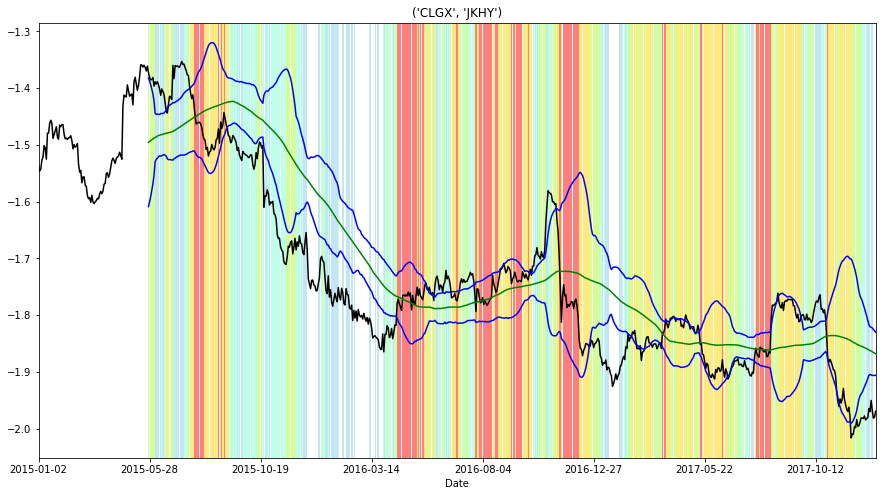

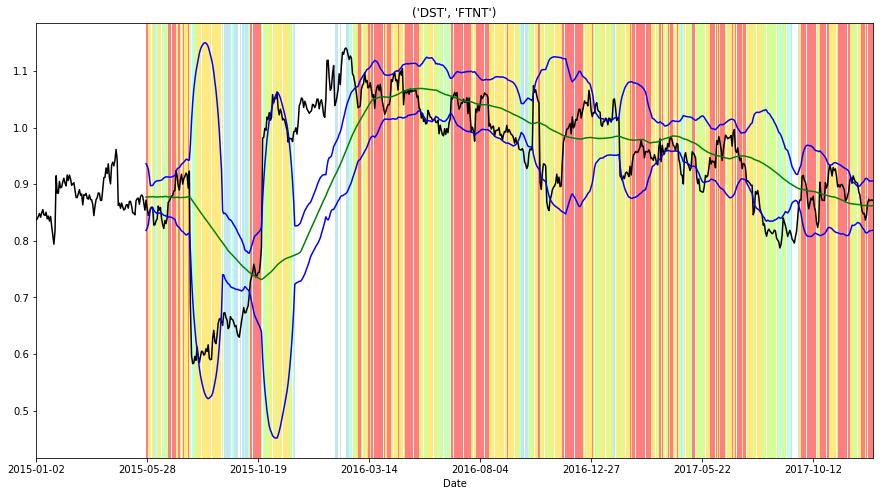

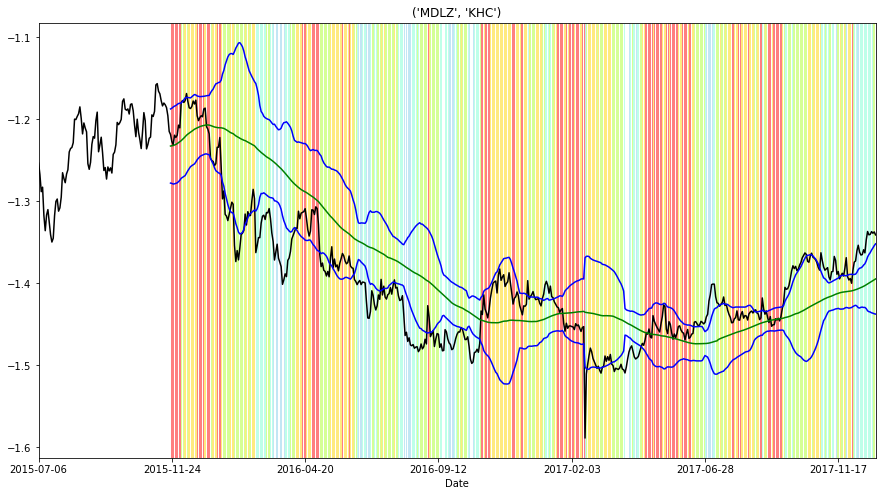

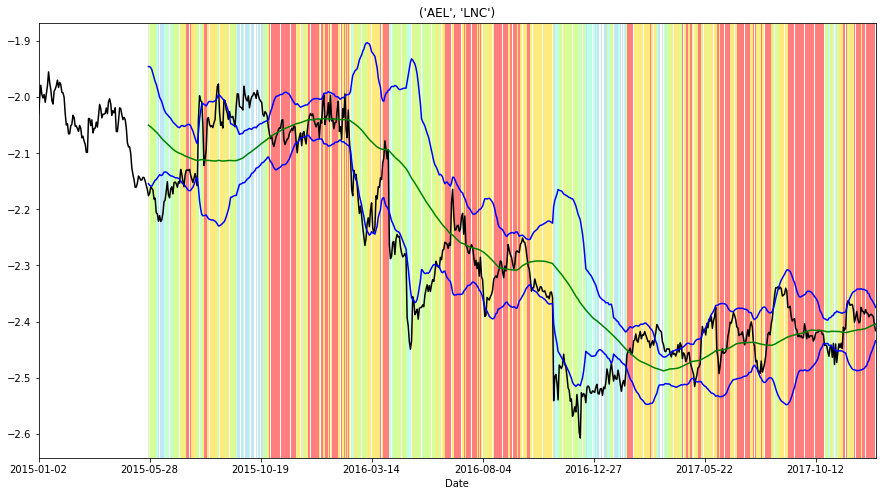

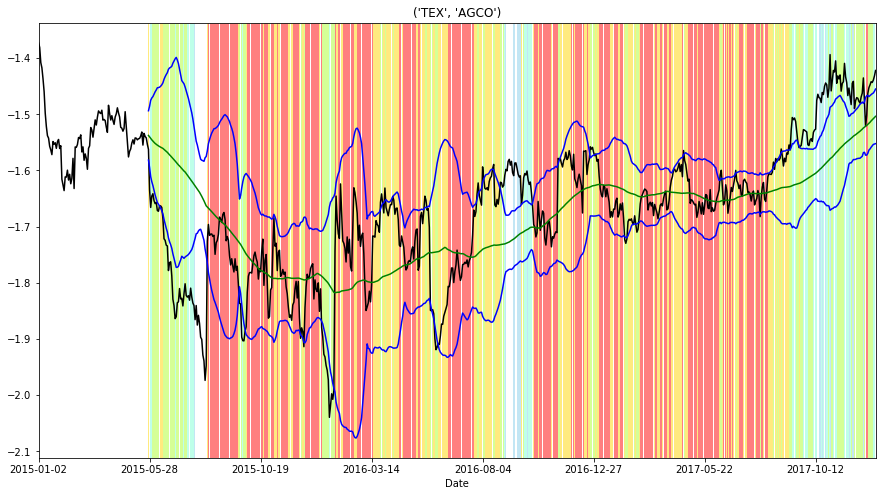

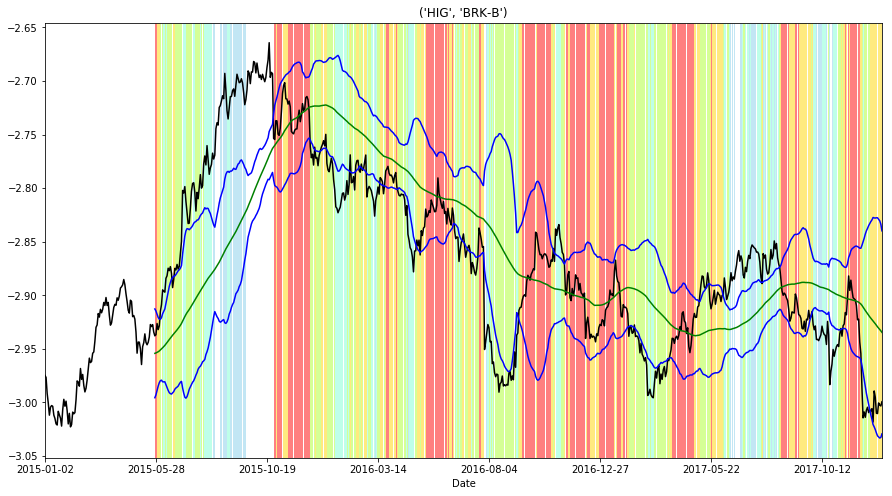

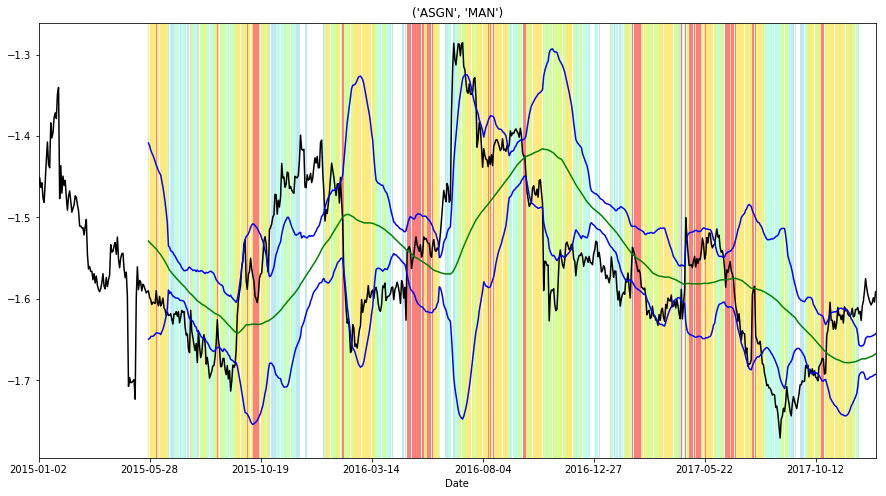

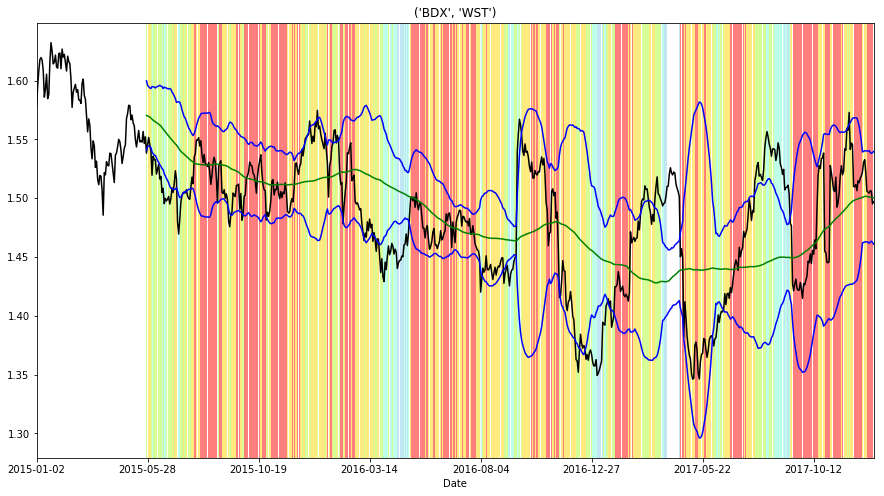

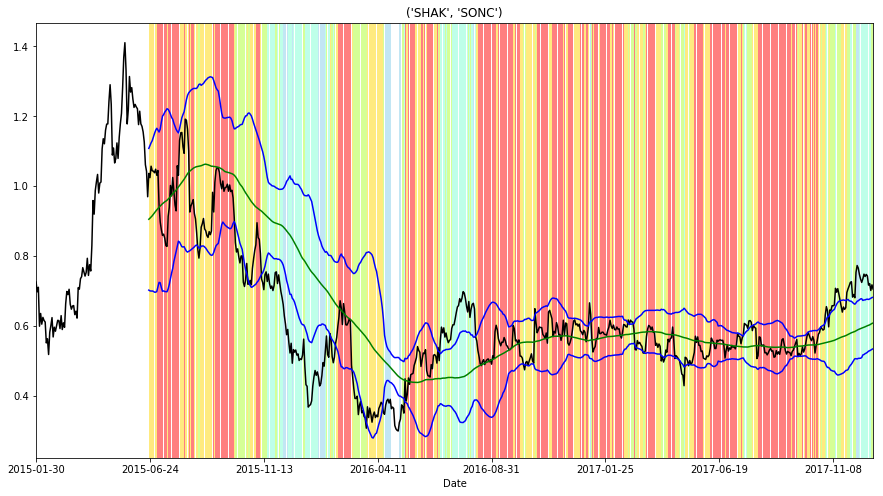

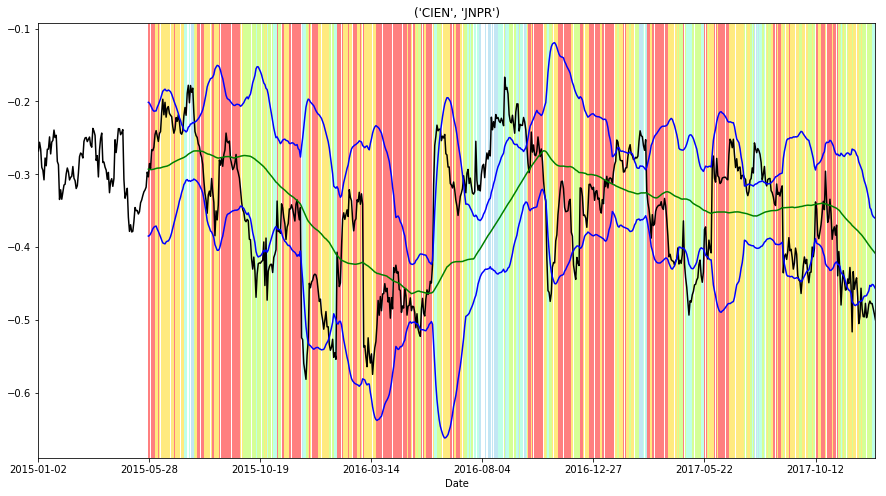

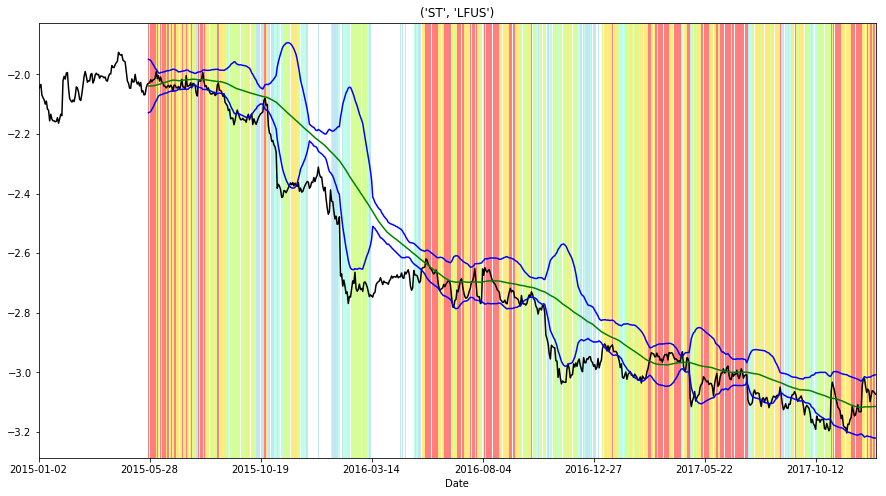

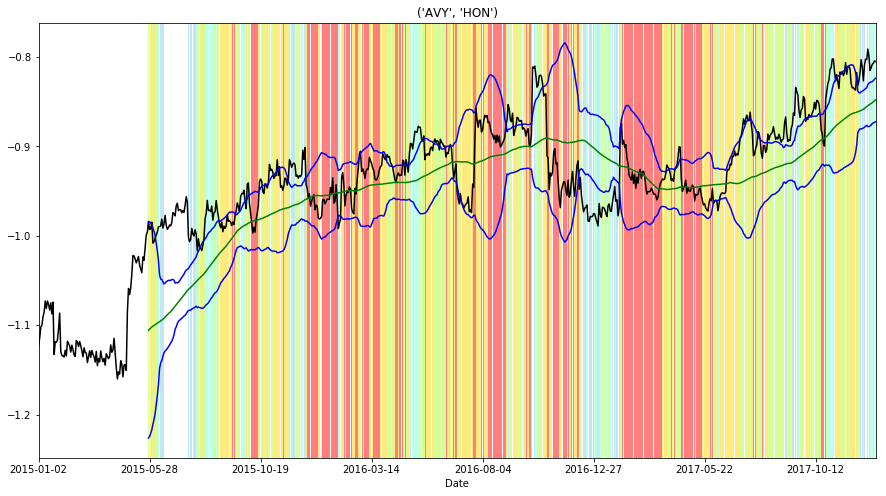

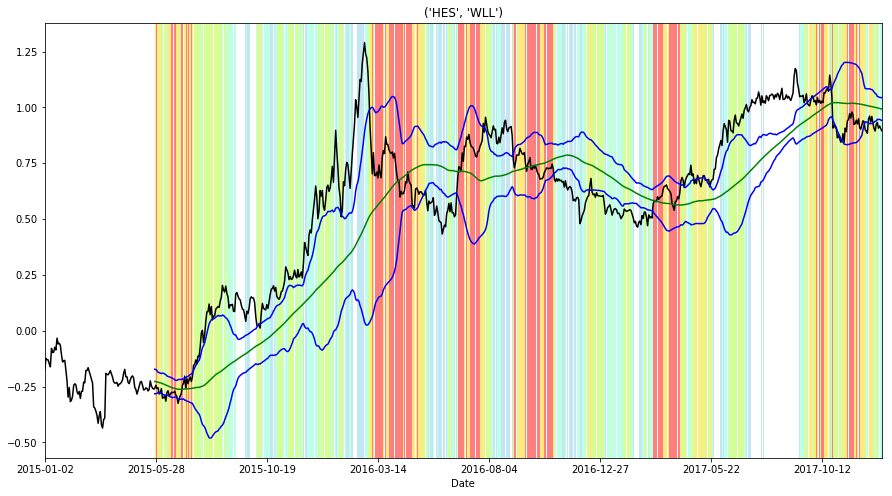

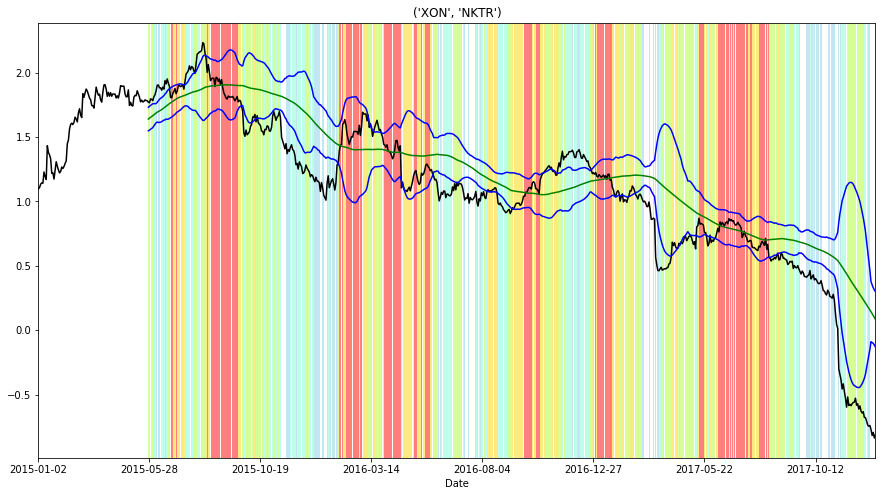

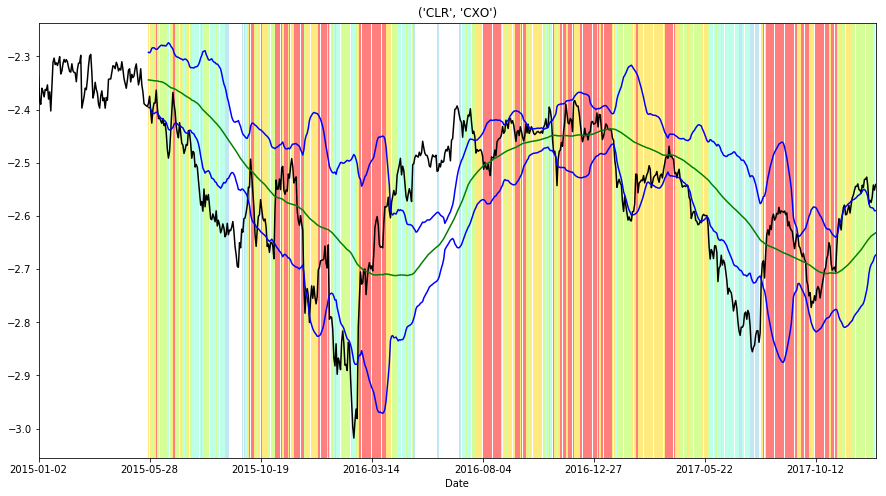

In [48]:
MA_LOOKBACK = 100
SD_LOOKBACK = 30

for i in range(len(PAIRS)):
    plt.figure(i)
    pair = PAIRS[i]
    zonified = zonify(RESIDUALS[pair], ma_lookback=MA_LOOKBACK, sd_lookback=SD_LOOKBACK)
    residual = RESIDUALS[pair]
    residual.plot(color='black')
    plt.title(pair)
    ma = residual.rolling(window=MA_LOOKBACK, center=False).mean()
    sd = residual.rolling(window=SD_LOOKBACK, center=False).std()
    ma.plot(color='g',figsize=(15,8))
    (ma+2*sd).plot(color='b')
    (ma-2*sd).plot(color='b')


    colors = {1.0:'red', 2.0:'gold', 3.0: 'greenyellow', 4.0: 'aquamarine', 5.0: 'skyblue'}
    for i in range(len(zonified.index)):
        abs_zone = np.abs(zonified.iloc[i])
        if abs_zone in colors:
            color = colors[abs_zone]
            plt.axvspan(i, i, alpha=0.5, color=color)

In [49]:
ZONED_RESIDUALS = dict()
CROSSOVER_SEQUENCES = dict()
for pair in PAIRS:
    zonified = zonify(RESIDUALS[pair], ma_lookback=MA_LOOKBACK, sd_lookback=SD_LOOKBACK, zone_width=1)
    crossover_sequence = mean_reversion_sequence(RESIDUALS[pair], MA_LOOKBACK, SD_LOOKBACK, sd_threshold=0)
    ZONED_RESIDUALS[pair] = zonified
    CROSSOVER_SEQUENCES[pair] = crossover_sequence

In [50]:
residual_df = pd.DataFrame(RESIDUALS)

In [51]:
zoned_df = pd.DataFrame(ZONED_RESIDUALS)

In [52]:
crossover_df = pd.DataFrame(CROSSOVER_SEQUENCES)

In [53]:
lb = max(MA_LOOKBACK, SD_LOOKBACK)

In [54]:
counts = {}
for p in PAIRS:
    p_zones = zoned_df[pair][lb:]
    p_crossovers = crossover_df[pair][lb:]
    for t in range(1, p_crossovers.size):
            if p_crossovers.iloc[t] == 1:
                #print('\nFrom ' + str(p_zones.iloc[t-1]) + ' to ' + str(p_zones.iloc[t]))
                k = (p_zones.iloc[t-1], p_zones.iloc[t])
                try:
                    counts[k] += 1
                except:
                    counts[k] = 1 
                
                assert(np.sign(p_zones.iloc[t-1]) != np.sign(p_zones.iloc[t]))
            else:
                assert(np.sign(p_zones.iloc[t-1]) == np.sign(p_zones.iloc[t]))




[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 15, 15, 15, 17, 17, 24]
Median: 3.0
Mean: 3.81224489796
Mode: ModeResult(mode=array([1]), count=array([46]))


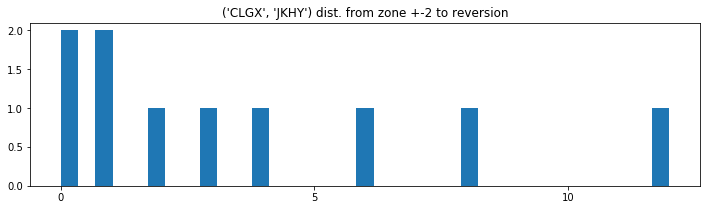

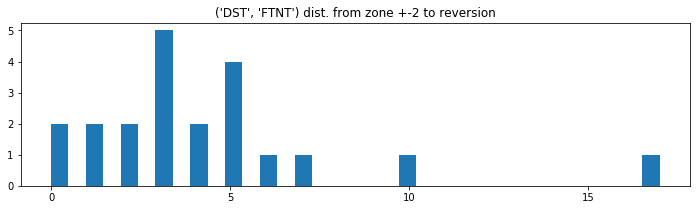

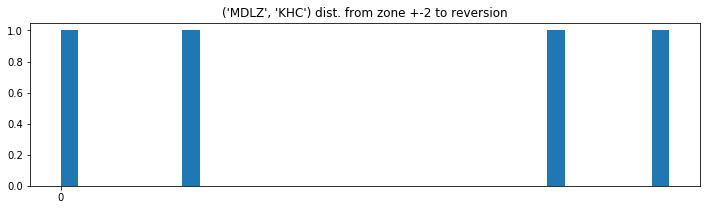

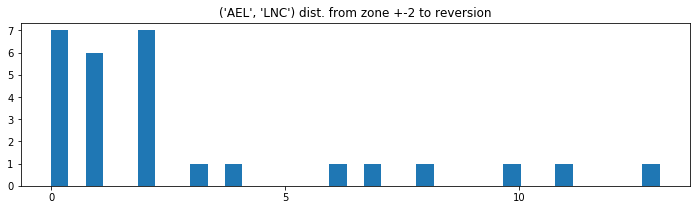

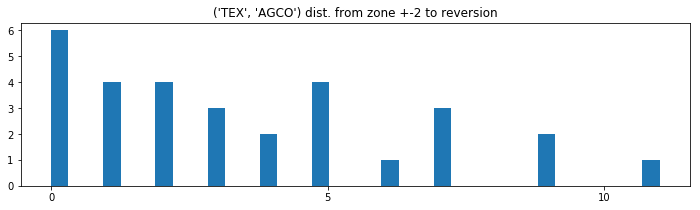

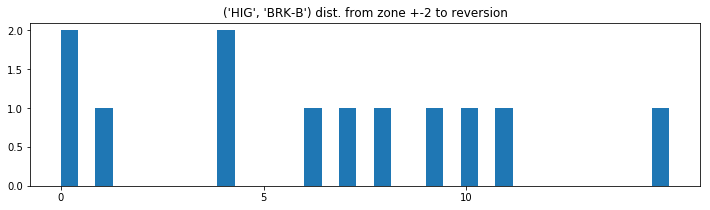

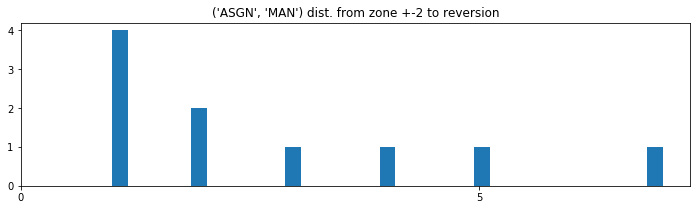

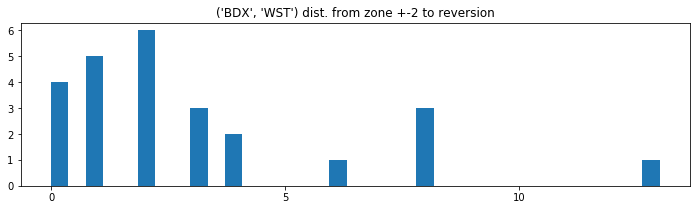

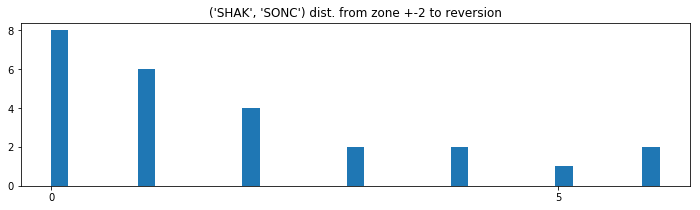

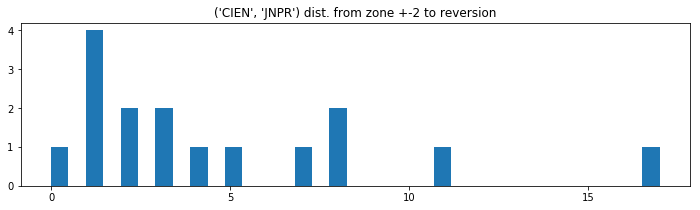

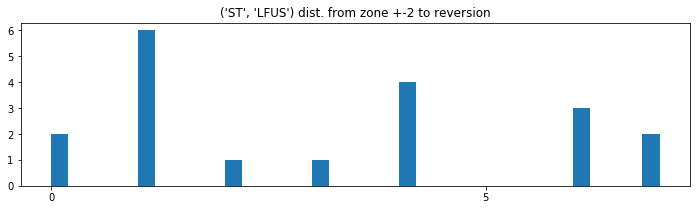

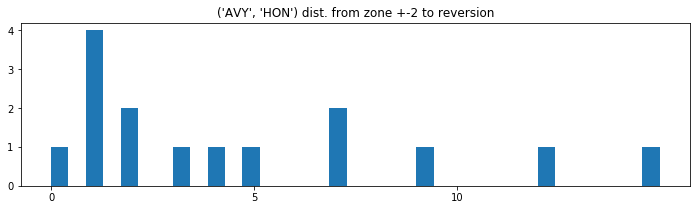

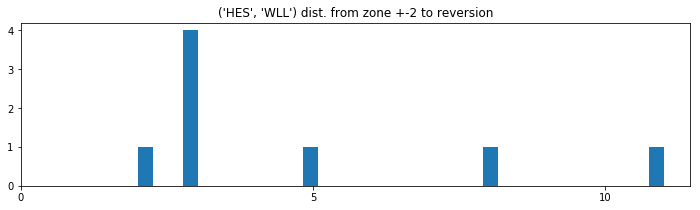

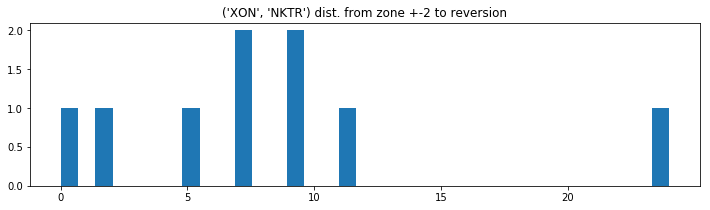

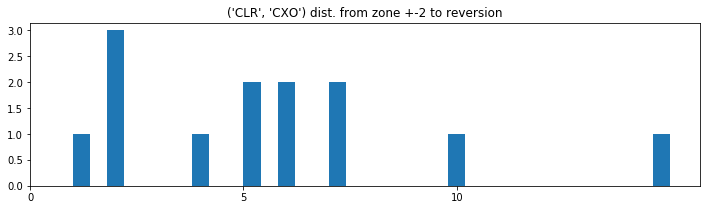

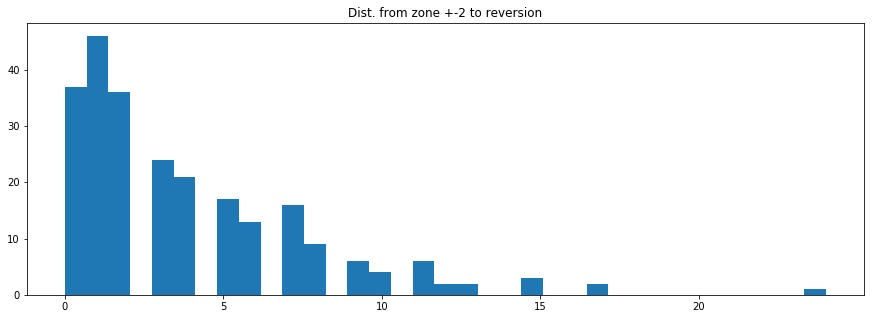

In [55]:
from scipy.stats import mode
def compute_dist_between_ones(arr, stat, plot=0):
    dist = 0
    all_dist = []
    for elem in arr:
        if elem == 1:
            all_dist.append(dist)
            dist = 0
        else:
            dist += 1
    if plot:
        plt.figure()
        plt.hist(all_dist, bins=50)
    return stat(all_dist)

def compute_reversion_windows(zones, crosses):
    all_dist = []
    t = 1
    while t < zones.size-1:
        try:
            if zones[t] >= 2 and zones[t+1] < 2:
                dist = 0
                while crosses[t] != 1:
                    if zones[t] > zones[t-1]:
                        # moved in the wrong direction, reset the count
                        dist = 0
                    else:
                        dist += 1
                    t += 1
                all_dist.append(dist)   
            elif zones[t] <= -2 and zones[t+1] > -2:
                dist = 0
                while crosses[t] != 1:
                    if zones[t] < zones[t-1]:
                        # moved in the wrong direction, reset the count
                        dist = 0
                    else:
                        dist += 1
                    t += 1
                all_dist.append(dist)
            t+=1
        except IndexError:
            break
    return all_dist
            

distances = []
for p in PAIRS:
    p_crossovers = crossover_df[p][lb:].dropna()
    p_zones = zoned_df[p][lb:].dropna()
    num_crossovers = np.sum(p_crossovers)
    pair_reversion_dist = compute_reversion_windows(p_zones, p_crossovers)
    plt.figure(figsize=(12,3))
    plt.title(str(p) + ' dist. from zone +-2 to reversion')
    plt.hist(pair_reversion_dist, bins=35)
    plt.xticks(np.arange(0, np.max(pair_reversion_dist), 5))
    distances.extend(pair_reversion_dist)

plt.figure(figsize=(15,5))
plt.title('Dist. from zone +-2 to reversion')
plt.hist(distances, bins=35)
plt.xticks(np.arange(0, np.max(distances), 5))

print('\n')
print(sorted(distances))
print('Median:',np.median(distances))
print('Mean:',np.mean(distances))
print('Mode:',mode(distances))


